## Introduction to Quantum Matcha Tea backend in QiboTN

#### Some imports

In [1]:
import time
import numpy as np
from scipy import stats

import qibo
from qibo import Circuit, gates, hamiltonians
from qibo.backends import construct_backend

from qmatchatea import QCConvergenceParameters

#### Some hyper parameters

In [2]:
# construct qibotn backend
qmatcha_backend = construct_backend(backend="qibotn", platform="qmatchatea")

# set number of qubits
nqubits = 4

# set numpy random seed
np.random.seed(42)

#### Constructing a parametric quantum circuit

In [3]:
def build_circuit(nqubits, nlayers):
    """Construct a parametric quantum circuit."""
    circ = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            circ.add(gates.RY(q=q, theta=0.))
            circ.add(gates.RZ(q=q, theta=0.))
        [circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    circ.add(gates.M(*range(nqubits)))
    return circ

In [4]:
circuit = build_circuit(nqubits=nqubits, nlayers=3)
circuit.draw()

0: ─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─M─
1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
3: ─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─M─


In [5]:
# Setting random parameters
circuit.set_parameters(
    parameters=np.random.uniform(-np.pi, np.pi, len(circuit.get_parameters())),
)

#### Setting up the tensor network simulator

Depending on the simulator, various parameters can be set. In the case of Quantum Matcha, we direclty exploit the `qmatchatea` interface and we construct a `QCConvergenceParameters` object (for more info [this is the link to the qmatchatea code](https://baltig.infn.it/quantum_matcha_tea/py_api_quantum_matcha_tea/-/blob/master/qmatchatea/utils/utils.py?ref_type=heads#L540)).

In [6]:
# We first define the useful objects 
convergence_parameters = QCConvergenceParameters(cut_ratio=1e-6, max_bond_dimension=50)

# And then call the dedicate configuration function
qmatcha_backend.configure_tn_simulation(
    convergence_params=convergence_parameters,
    ansatz="MPS",
)

#### Executing through the backend

The `backend.execute_circuit` method can be used then. We can simulate results in three ways:
1. reconstruction of the final state (statevector like, only if `nqubits < 20` due to Quantum Matcha Tea setup);
2. computation of the relevant probabilities of the final state. There are three way of doing so, but we will see it directly into the docstrings;
3. reconstruction of the relevant state's frequencies (only if `nshots` is not `None`).

In [7]:
qmatcha_backend.execute_circuit?

Signature:
qmatcha_backend.execute_circuit(
    circuit,
    initial_state=None,
    nshots=None,
    prob_type='U',
    **prob_kwargs,
)
Docstring:
Execute a Qibo quantum circuit using tensor network simulation.

This method returns a ``TensorNetworkResult`` object, which provides:
  - Reconstruction of the system state (if the system size is < 20).
  - Frequencies (if the number of shots is specified).
  - Probabilities computed using various methods.

The following probability computation methods are available, as implemented 
in Quantum Matcha Tea:
  - **"E" (Even):** Probabilities are computed by evenly descending the probability tree, 
    pruning branches (states) with probabilities below a threshold.
  - **"G" (Greedy):** Probabilities are computed by following the most probable states 
    in descending order until reaching a given coverage (sum of probabilities).
  - **"U" (Unbiased):** An optimal probability measure that is unbiased and designed 
    for best performance. Se

In [8]:
# Simple execution (defaults)
outcome = qmatcha_backend.execute_circuit(circuit=circuit)

# Print outcome
vars(outcome)

{'nqubits': 4,
 'backend': QMatchaTeaBackend(),
 'measures': None,
 'measured_probabilities': {'U': {'0000': (0.0, 0.08390937969317301),
   '0001': (0.08390937969317301, 0.08858639088838134),
   '0010': (0.08858639088838131, 0.1832549957082757),
   '0011': (0.1832549957082757, 0.25896776804349736),
   '0100': (0.2589677680434974, 0.33039716334036867),
   '0101': (0.33039716334036867, 0.386620221067355),
   '0110': (0.3866202210673549, 0.4380808691410473),
   '0111': (0.4380808691410473, 0.47837271988834),
   '1000': (0.47837271988834, 0.5916815553716759),
   '1001': (0.5916815553716759, 0.5972581739037379),
   '1010': (0.5972581739037378, 0.6359857590550054),
   '1011': (0.6359857590550054, 0.6894851559808782),
   '1100': (0.6894851559808783, 0.7030911408535467),
   '1101': (0.7030911408535467, 0.8264027395524797),
   '1110': (0.8264027395524797, 0.8981519382820797),
   '1111': (0.8981519382820797, 0.9999999999999998)},
  'E': [None],
  'G': [None]},
 'prob_type': 'U',
 'statevector': 

In [9]:
# Execution with a specific probability type
# We use here "E", which is cutting some of the components if under a threshold
outcome = qmatcha_backend.execute_circuit(
    circuit=circuit,
    prob_type="E",
    prob_threshold=0.05,
)

# Print outcome
vars(outcome)

{'nqubits': 4,
 'backend': QMatchaTeaBackend(),
 'measures': None,
 'measured_probabilities': {'U': [None],
  'E': {'0000': 0.08390937969317301,
   '0010': 0.09466860481989439,
   '0011': 0.07571277233522165,
   '0100': 0.07142939529687124,
   '0101': 0.05622305772698632,
   '0110': 0.05146064807369245,
   '1000': 0.11330883548333581,
   '1011': 0.053499396925872765,
   '1101': 0.12331159869893296,
   '1110': 0.07174919872960005,
   '1111': 0.10184806171792007},
  'G': [None]},
 'prob_type': 'E',
 'statevector': array([ 0.08809627-0.27595005j,  0.24859731-0.22695421j,
         0.18807826+0.18988408j,  0.09444097+0.06846085j,
         0.00470148+0.30764671j,  0.17371395-0.09247188j,
        -0.18900305+0.12545316j, -0.17359753+0.20399288j,
        -0.0517478 +0.04471215j, -0.0411739 -0.06230031j,
         0.22377064+0.07842041j, -0.21784975-0.27541439j,
        -0.27208941+0.04098933j, -0.22748127+0.04185292j,
         0.17105258-0.10503745j, -0.01729753-0.31866731j])}

---

One can access to the specific contents of the simulation outcome.

In [10]:
print(f"Probabilities:\n {outcome.probabilities()}\n")
print(f"State:\n {outcome.state()}\n")

Probabilities:
 {'0000': 0.08390937969317301, '0010': 0.09466860481989439, '0011': 0.07571277233522165, '0100': 0.07142939529687124, '0101': 0.05622305772698632, '0110': 0.05146064807369245, '1000': 0.11330883548333581, '1011': 0.053499396925872765, '1101': 0.12331159869893296, '1110': 0.07174919872960005, '1111': 0.10184806171792007}

State:
 [ 0.08809627-0.27595005j  0.24859731-0.22695421j  0.18807826+0.18988408j
  0.09444097+0.06846085j  0.00470148+0.30764671j  0.17371395-0.09247188j
 -0.18900305+0.12545316j -0.17359753+0.20399288j -0.0517478 +0.04471215j
 -0.0411739 -0.06230031j  0.22377064+0.07842041j -0.21784975-0.27541439j
 -0.27208941+0.04098933j -0.22748127+0.04185292j  0.17105258-0.10503745j
 -0.01729753-0.31866731j]



---

But frequencies cannot be accessed, since no shots have been set.

In [11]:
# print(f"Frequencies:\n {outcome.frequencies()}\n")

---

We can then repeat the execution by setting the number of shots

In [12]:
# Execution with a specific probability type
# We use here "E", which is cutting some of the components if under a threshold
outcome = qmatcha_backend.execute_circuit(
    circuit=circuit,
    nshots=1024,
    prob_type="E",
    prob_threshold=0.05,
)

# Print outcome
vars(outcome)

{'nqubits': 4,
 'backend': QMatchaTeaBackend(),
 'measures': {'0000': 88,
  '0001': 7,
  '0010': 90,
  '0011': 78,
  '0100': 72,
  '0101': 56,
  '0110': 47,
  '0111': 41,
  '1000': 120,
  '1001': 7,
  '1010': 41,
  '1011': 53,
  '1100': 20,
  '1101': 129,
  '1110': 73,
  '1111': 102},
 'measured_probabilities': {'U': [None],
  'E': {'0000': 0.08390937969317301,
   '0010': 0.09466860481989439,
   '0011': 0.07571277233522165,
   '0100': 0.07142939529687124,
   '0101': 0.05622305772698632,
   '0110': 0.05146064807369245,
   '1000': 0.11330883548333581,
   '1011': 0.053499396925872765,
   '1101': 0.12331159869893296,
   '1110': 0.07174919872960005,
   '1111': 0.10184806171792007},
  'G': [None]},
 'prob_type': 'E',
 'statevector': array([ 0.08809627-0.27595005j,  0.24859731-0.22695421j,
         0.18807826+0.18988408j,  0.09444097+0.06846085j,
         0.00470148+0.30764671j,  0.17371395-0.09247188j,
        -0.18900305+0.12545316j, -0.17359753+0.20399288j,
        -0.0517478 +0.04471215j,

In [13]:
# And then finally access frequencies!
print(f"Frequencies:\n {outcome.frequencies()}\n")

Frequencies:
 {'0000': 88, '0001': 7, '0010': 90, '0011': 78, '0100': 72, '0101': 56, '0110': 47, '0111': 41, '1000': 120, '1001': 7, '1010': 41, '1011': 53, '1100': 20, '1101': 129, '1110': 73, '1111': 102}



#### Testing the performances

In [14]:
qmatcha_range = range(2, 100, 2)
qibojit_threshold = 28
qibojit_range = range(2, qibojit_threshold, 2)

In [ ]:
qmatcha_times, qmatcha_errs = [], []
qibojit_times, qibojit_errs = [], []

qibojit_backend = construct_backend("qibojit", platform="numba")
qibo.set_threads(2)


for q in qmatcha_range:
    print(f"Executing for {q} qubits")
    # Build the circuit
    circuit = build_circuit(q, 1)

    reasonable_exp = min(13, int(q / 2))
    
    qmatcha_backend.configure_tn_simulation(
        convergence_params=QCConvergenceParameters(max_bond_dimension=2**reasonable_exp),
        ansatz="MPS"
    )

    tmp_qmatcha_times, tmp_qibojit_times = [], []    
    for i in range(20):
        # Set random parameters
        circuit.set_parameters(parameters=np.random.uniform(-np.pi, np.pi, len(circuit.get_parameters())))
        
        # Measure QMatcha execution time
        print(f"1. ---- QMatcha") if i == 0 else None
        start_time = time.time()
        outcome = qmatcha_backend.execute_circuit(circuit=circuit)
        tmp_qmatcha_times.append(time.time() - start_time)

        if q < qibojit_threshold:
            
            if i == 0:
                outcome = qibojit_backend.execute_circuit(circuit=circuit)
            
            # Measure Qibojit execution time
            print(f"2. ---- Qibojit") if i == 0 else None
            start_time = time.time()
            outcome = qibojit_backend.execute_circuit(circuit=circuit)
            tmp_qibojit_times.append(time.time() - start_time)
        
    qmatcha_times.append(np.median(tmp_qmatcha_times))
    qmatcha_errs.append(stats.median_abs_deviation(tmp_qmatcha_times))
    
    if q < qibojit_threshold:
        qibojit_times.append(np.median(tmp_qibojit_times))
        qibojit_errs.append(stats.median_abs_deviation(tmp_qibojit_times))

In [15]:
# Saving data
# np.save(arr=qmatcha_times, file="qmatcha_times")
# np.save(arr=qibojit_times, file="qibojit_times")
# np.save(arr=qmatcha_errs, file="qmatcha_errs")
# np.save(arr=qibojit_errs, file="qibojit_errs")

qmatcha_times = np.load("qmatcha_times.npy")
qmatcha_errs = np.load("qmatcha_errs.npy")
qibojit_times = np.load("qibojit_times.npy")
qibojit_errs = np.load("qibojit_errs.npy")

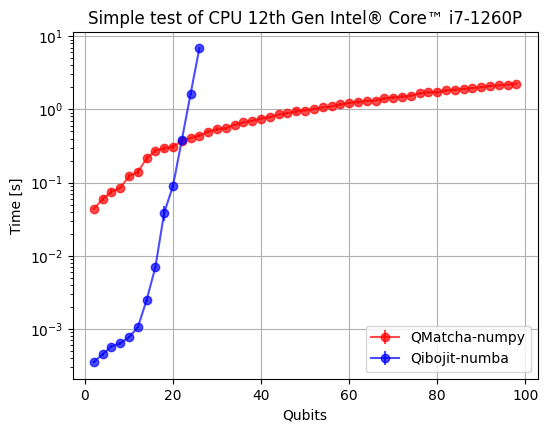

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6 * 6/8))
plt.title("Simple test of CPU 12th Gen Intel® Core™ i7-1260P")
plt.errorbar(qmatcha_range, qmatcha_times, yerr=qmatcha_errs,  marker="o", color="red", label="QMatcha-numpy", alpha=0.7)
plt.errorbar(qibojit_range, qibojit_times, yerr=qibojit_errs,  marker="o", color="blue", label="Qibojit-numba", alpha=0.7)
plt.legend()
plt.xlabel("Qubits")
plt.ylabel("Time [s]")
plt.grid(True)
plt.yscale("log")

### Compute expectation values

In [17]:
from qibo.symbols import Z, X

In [18]:
# We are going to compute the expval of an Hamiltonian
# On the state prepared by the following circuit
circuit.draw()

circuit.set_parameters(
    np.random.randn(len(circuit.get_parameters()))
)

0: ─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─M─
1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
3: ─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─M─


In [19]:
# We can create an Hamiltonian form
form = 0.5 * Z(0) * Z(1) +- 1.5 *  X(0) * Z(2) + Z(3)
form

-1.5*X0*Z2 + 0.5*Z0*Z1 + Z3

In [20]:
qmatcha_backend.expectation?

Signature: qmatcha_backend.expectation(circuit, observable)
Docstring:
Compute the expectation value of a Qibo-friendly ``observable``
on the Tensor Network constructed from a Qibo ``circuit``.

This method takes a Qibo-style symbolic Hamiltonian (e.g., `X(0)*Z(1) + 2.0*Y(2)*Z(0)`) 
as the observable, converts it into a Quantum Matcha Tea (qmatchatea) observable
(using `TNObsTensorProduct` and `TNObsWeightedSum`), and computes its expectation 
value using the provided circuit.

Args:
    circuit: A Qibo quantum circuit object on which the expectation value
        is computed. The circuit should be compatible with the qmatchatea
        Tensor Network backend.
    observable: The observable whose expectation value we want to compute. 
        This must be provided in the symbolic Hamiltonian form supported by Qibo
        (e.g., `X(0)*Y(1)` or `Z(0)*Z(1) + 1.5*Y(2)`).

Returns:
    qmatchatea.SimulationResult [TEMPORARY]
File:      ~/Documents/PhD/qibotn/src/qibotn/backends/qmatchatea.

In [22]:
qmatcha_backend.expectation(
    circuit=circuit,
    observable=form,
)

0.41329220819521995

In [23]:
# Try with Qibo

hamiltonian = hamiltonians.SymbolicHamiltonian(form)
hamiltonian.expectation(circuit().state())

[Qibo 0.2.16|INFO|2025-01-28 22:13:05]: Using qibojit (numba) backend on /CPU:0


0.4132922081952206

They match! 🥳